The imports we will use

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import torch.utils.tensorboard as tensorboard
from torch.utils.tensorboard import SummaryWriter
from datasets import load_dataset
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensor board

In [2]:
writer = SummaryWriter('runs/Efficient Net')

Loading the data

In [3]:
dataset = load_dataset('ethz/food101')

Understanding the enemy 

In [4]:
# Inspect the dataset
print("Dataset structure:")
print(dataset)


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})


choosing to work with gpu if available

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=0)

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
def collate_fn(batch):
    images = []
    labels = []
    for item in batch:
        image = item['image'].convert('RGB')  # Ensure image is in RGB format
        image = data_transforms['train'](image)  # Apply transformations
        images.append(image)
        labels.append(item['label'])
    return {
        'image': torch.stack(images),
        'label': torch.tensor(labels)
    }

In [9]:
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn),
    'validation': DataLoader(dataset['validation'], batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)
}
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'validation']}
class_names = dataset['train'].features['label'].names

In [10]:
#understanding the data pt2
# Check the shapes, data types, and labels
for split in ['train', 'validation']:
    print(f"\nAnalyzing {split} split:")
    data = dataset[split]
    print(f"Number of samples: {len(data)}")
    
    # Get a sample image and label
    sample = data[0]
    image = sample['image']
    label = sample['label']
    
    print(f"Shape of sample image: {image.size}")
    print(f"Data type of sample image: {image.mode}")
    print(f"Label of sample image: {label}")


Analyzing train split:
Number of samples: 75750
Shape of sample image: (384, 512)
Data type of sample image: RGB
Label of sample image: 6

Analyzing validation split:
Number of samples: 25250
Shape of sample image: (512, 512)
Data type of sample image: RGB
Label of sample image: 6


In [11]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [12]:
def imshow(inp, title=None):
    
    plt.figure(figsize=(64, 64))  # Adjust this to make it larger or smaller
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title, fontsize=32)  # Adjust fontsize as needed
    
    plt.axis('off')  # Turn off axis
    plt.show()

In [13]:
batch = next(iter(dataloaders['train']))
inputs, classes = batch['image'], batch['label']

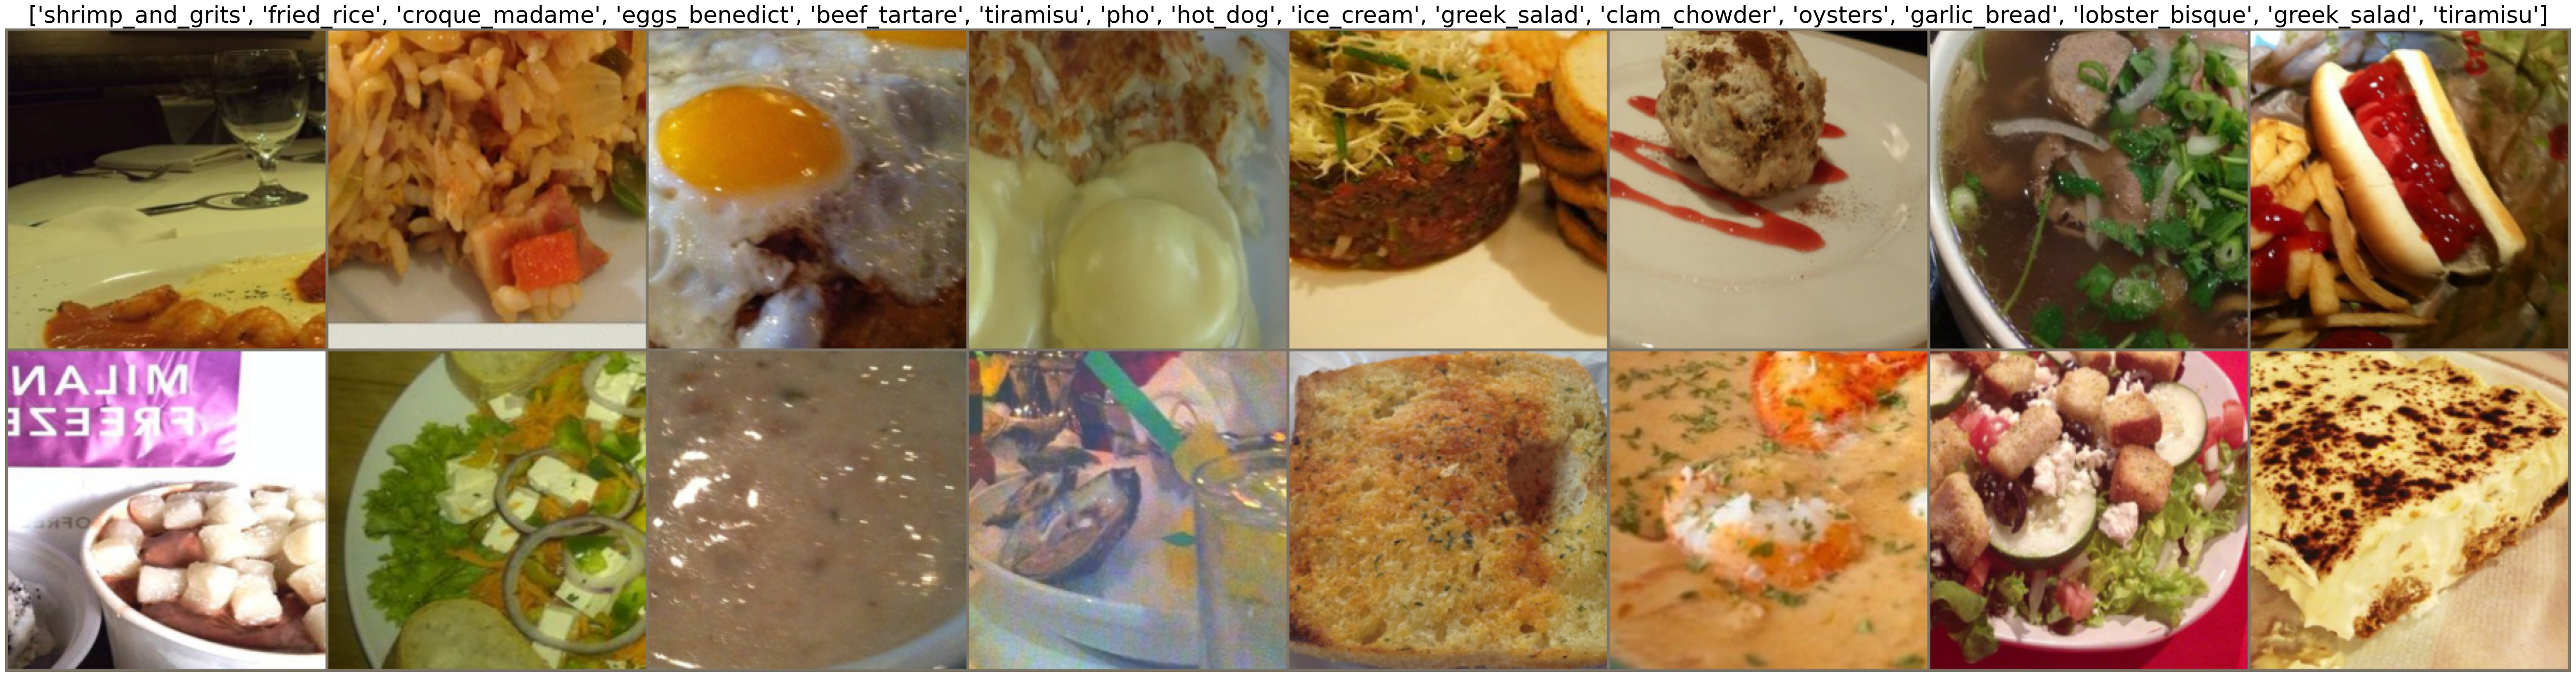

In [14]:
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [15]:
def train(model,criterion,optimizer,dataloaders,dataset_sizes,device):
    model.train()
    running_loss = 0.0
    corrects = 0 
    total = 0 

    for batch in tqdm(dataloaders['train']):
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = corrects / total
    
    print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    return epoch_loss

In [ ]:
def validate(model,dataloaders,dataset_size,criterion,device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    

    with torch.no_grad():
        for batch in tqdm(dataloaders['validation']):
            inputs = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss/dataset_size['validation']
    accuracy = correct / total


    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    return epoch_loss, accuracy, precision, recall, f1, conf_matrix

In [18]:
model_ft = models.efficientnet_b3(weights='DEFAULT')

num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 101)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
def plot_confusion_matrix():
  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')

  return fig

In [20]:
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

best_f1 = 0.0
best_precision = 0.0
best_recall = 0.0
best_accuracy = 0.0

start_time = time.time()


for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    train_loss = train(model_ft, criterion, optimizer_ft, dataloaders, dataset_sizes, device)
    val_loss, val_accuracy, precision, recall, f1, conf_matrix = validate(model_ft, dataloaders, dataset_sizes, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1s.append(f1)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_f1 = f1
        best_precision = precision
        best_recall = recall

    if epoch%2==0:
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
        writer.add_scalar('Precision/val', precision, epoch)
        writer.add_scalar('Recall/val', recall, epoch)
        writer.add_scalar('F1 Score/val', f1, epoch)
        writer.add_figure('Confusion Matrix', plot_confusion_matrix(), epoch)


end_time = time.time()
total_time = end_time - start_time
print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
print(f'Best Validation Accuracy: {best_accuracy:.4f}')
print(f'Best Precision: {best_precision:.4f}')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best F1 Score: {best_f1:.4f}')

Epoch 1/10
----------


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4571/4735 [17:38<00:38,  4.31it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [18:16<00:00,  4.32it/s]


Train Loss: 2.2501, Accuracy: 0.4714


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:10<00:00,  8.29it/s]


Validation Loss: 1.0671, Accuracy: 0.7189
Precision: 0.7191, Recall: 0.7189, F1 Score: 0.7141
Confusion Matrix:
[[ 94   1  17 ...   4   0  17]
 [  0 190   0 ...   1   0   0]
 [  8   0 192 ...   1   0   1]
 ...
 [  1   0   0 ... 188   0   1]
 [  1   2   0 ...   0 106   0]
 [  5   1   0 ...   1   0 203]]
Epoch 2/10
----------


  7%|█████▋                                                                         | 344/4735 [01:23<18:09,  4.03it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [19:08<00:00,  4.12it/s]


Train Loss: 1.4057, Accuracy: 0.6436


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:06<00:00,  8.45it/s]


Validation Loss: 0.9092, Accuracy: 0.7583
Precision: 0.7595, Recall: 0.7583, F1 Score: 0.7546
Confusion Matrix:
[[114   0  14 ...   2   0  12]
 [  0 183   0 ...   0   0   0]
 [  4   0 220 ...   0   0   0]
 ...
 [  2   0   1 ... 197   0   1]
 [  0   0   0 ...   0 125   0]
 [  1   0   0 ...   0   0 211]]
Epoch 3/10
----------


 18%|█████████████▉                                                                 | 839/4735 [03:19<14:54,  4.36it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [18:19<00:00,  4.31it/s]


Train Loss: 1.2071, Accuracy: 0.6901


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:03<00:00,  8.60it/s]


Validation Loss: 0.8208, Accuracy: 0.7782
Precision: 0.7799, Recall: 0.7782, F1 Score: 0.7759
Confusion Matrix:
[[128   1   7 ...   2   0   8]
 [  0 197   0 ...   0   0   0]
 [  8   1 205 ...   1   1   0]
 ...
 [  3   0   0 ... 200   0   1]
 [  0   1   0 ...   0 136   0]
 [  1   0   0 ...   1   0 214]]
Epoch 4/10
----------


 19%|███████████████                                                                | 905/4735 [03:28<14:40,  4.35it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [18:10<00:00,  4.34it/s]


Train Loss: 1.0917, Accuracy: 0.7174


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:02<00:00,  8.64it/s]


Validation Loss: 0.7641, Accuracy: 0.7922
Precision: 0.7939, Recall: 0.7922, F1 Score: 0.7900
Confusion Matrix:
[[157   1   8 ...   3   0  10]
 [  0 197   0 ...   0   0   1]
 [  8   0 221 ...   0   0   0]
 ...
 [  2   0   0 ... 186   0   0]
 [  0   1   0 ...   0 149   1]
 [  2   0   1 ...   0   0 225]]
Epoch 5/10
----------


 17%|█████████████▎                                                                 | 798/4735 [03:03<14:52,  4.41it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [18:10<00:00,  4.34it/s]


Train Loss: 0.9973, Accuracy: 0.7399


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:03<00:00,  8.62it/s]


Validation Loss: 0.7445, Accuracy: 0.8015
Precision: 0.8031, Recall: 0.8015, F1 Score: 0.7998
Confusion Matrix:
[[146   0  11 ...   2   0   1]
 [  0 176   0 ...   0   0   0]
 [  4   0 218 ...   2   0   0]
 ...
 [  1   0   0 ... 195   0   0]
 [  0   0   0 ...   0 149   0]
 [  3   0   0 ...   0   0 211]]
Epoch 6/10
----------


 72%|████████████████████████████████████████████████████████▎                     | 3417/4735 [13:07<05:11,  4.23it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [18:10<00:00,  4.34it/s]


Train Loss: 0.9353, Accuracy: 0.7546


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:03<00:00,  8.60it/s]


Validation Loss: 0.7275, Accuracy: 0.8057
Precision: 0.8071, Recall: 0.8057, F1 Score: 0.8043
Confusion Matrix:
[[135   1  12 ...   1   0   8]
 [  0 181   0 ...   0   0   0]
 [  5   0 217 ...   0   0   1]
 ...
 [  2   0   1 ... 197   1   1]
 [  0   0   0 ...   0 178   0]
 [  2   0   0 ...   0   0 218]]
Epoch 7/10
----------


 99%|█████████████████████████████████████████████████████████████████████████████ | 4675/4735 [17:58<00:13,  4.29it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [18:12<00:00,  4.33it/s]


Train Loss: 0.8875, Accuracy: 0.7661


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:03<00:00,  8.59it/s]


Validation Loss: 0.7175, Accuracy: 0.8073
Precision: 0.8081, Recall: 0.8073, F1 Score: 0.8057
Confusion Matrix:
[[140   1  11 ...   1   0   5]
 [  1 189   0 ...   0   0   0]
 [  7   0 221 ...   0   0   0]
 ...
 [  4   0   0 ... 213   0   1]
 [  0   0   0 ...   0 148   0]
 [  0   0   0 ...   0   0 227]]
Epoch 8/10
----------


 61%|███████████████████████████████████████████████▍                              | 2879/4735 [11:03<07:04,  4.37it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [18:11<00:00,  4.34it/s]


Train Loss: 0.8477, Accuracy: 0.7751


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:03<00:00,  8.62it/s]


Validation Loss: 0.7096, Accuracy: 0.8135
Precision: 0.8174, Recall: 0.8135, F1 Score: 0.8131
Confusion Matrix:
[[116   1  11 ...   3   0   8]
 [  0 201   0 ...   0   0   0]
 [  2   0 220 ...   0   1   0]
 ...
 [  1   0   0 ... 207   0   0]
 [  0   1   0 ...   0 164   0]
 [  0   0   0 ...   0   0 223]]
Epoch 9/10
----------


 16%|████████████▌                                                                  | 750/4735 [02:52<15:15,  4.35it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [18:10<00:00,  4.34it/s]


Train Loss: 0.7996, Accuracy: 0.7905


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:03<00:00,  8.60it/s]


Validation Loss: 0.7001, Accuracy: 0.8154
Precision: 0.8158, Recall: 0.8154, F1 Score: 0.8140
Confusion Matrix:
[[142   1   8 ...   2   0   5]
 [  0 204   0 ...   0   0   0]
 [  1   0 218 ...   1   0   1]
 ...
 [  3   0   0 ... 208   0   0]
 [  0   0   0 ...   1 168   0]
 [  1   1   0 ...   0   0 221]]
Epoch 10/10
----------


 54%|█████████████████████████████████████████▊                                    | 2535/4735 [09:43<08:27,  4.34it/s]C:\Users\pc\miniconda3\envs\newtorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████| 4735/4735 [18:10<00:00,  4.34it/s]


Train Loss: 0.7610, Accuracy: 0.7975


100%|██████████████████████████████████████████████████████████████████████████████| 1579/1579 [03:03<00:00,  8.58it/s]

Validation Loss: 0.7038, Accuracy: 0.8163
Precision: 0.8176, Recall: 0.8163, F1 Score: 0.8153
Confusion Matrix:
[[151   1  15 ...   2   1   9]
 [  0 207   0 ...   0   0   0]
 [  2   0 226 ...   0   0   0]
 ...
 [  1   0   1 ... 193   0   3]
 [  0   0   0 ...   0 183   0]
 [  2   0   1 ...   1   0 219]]
Training complete in 214m 16s
Best Validation Accuracy: 0.8163
Best Precision: 0.8176
Best Recall: 0.8163
Best F1 Score: 0.8153


In [21]:
torch.save(model_ft.state_dict(), 'Efficient NetB3_Adam.pth')